## Initialize

In [2]:
import pickle, os, sys

import numpy as np
import random
from pathlib import Path
from deap import creator, gp, base, tools
import librosa

import yaml

import pandas as pd
import matplotlib.pyplot as plt
import pygraphviz as pgv
plt.ion()

from ipywidgets import interactive, interact
import ipywidgets as widgets
import IPython.display as ip_disp
from  IPython.display import HTML

from supriya import SynthDefBuilder, CalculationRate
from supriya.ugens import Out, K2A, SinOsc
import numbers
import operator

import soundfile as sf

# Necessary to be able to import code from the main Python files
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import nest_asyncio
nest_asyncio.apply()

## List runs

In [25]:
log_directory = '../logs/pickle/moo_experiment/'
log_directories = sorted(os.listdir(log_directory))
selection_widget = widgets.SelectMultiple(
    options=log_directories,
    value=[],
    description='Runs to export',
    disabled=False,
    rows=len(log_directories)
)
display(selection_widget)

SelectMultiple(description='Runs to export', options=('moo_mel_mfcc', 'moo_mel_mfcc_zc', 'moo_mel_zc', 'moo_mf…

In [26]:
export_dir = '../results/'

with open(f"{log_directory}{selection_widget.value[0] + '/00/'}/config.yaml", "r") as file:
    config = yaml.safe_load(file)

label_audio_name = config['target_audio']['name']
sampling_rate = config['target_audio']['sample_rate']

label_audio_path = "../sounds/" + label_audio_name + ".aiff"
label_audio, _ = librosa.load(label_audio_path, sr=sampling_rate)

duration = librosa.get_duration(y=label_audio, sr=sampling_rate)

In [27]:
def load_dataframe(run_directory, use_jax):    
    populations = []
    
     # Iterate through all files in the directory and load the individual populations
    for f in os.listdir(os.fsencode(run_directory)):
        file_name = os.fsdecode(f)
        
        if not file_name.endswith('.pkl'):
            continue
        generation_index = int(file_name.rsplit('.')[0], base=10)
        file = open(run_directory + file_name, 'rb')
        population = pickle.load(file)
        file.close()

        with open(run_directory + "config.yaml", "r") as file:
            config = yaml.safe_load(file)
        
        features = config['evolutionary_algorithm']['fitness_function']['feature']
        
        new_stats = []
        for index, individual in enumerate(population):
            individual_stats = {}
            individual_stats['generation'] = generation_index
            individual_stats['individual'] = index

            for fitness_index, fitness in enumerate(individual.fitness.values):
                individual_stats[features[fitness_index]] = float(fitness)
            
            individual_stats['depth'] = individual.height
            individual_stats['valid'] = not np.isinf(individual.fitness.values[0])
            
            individual_stats['expression'] = str(individual)
            if use_jax:
                individual_stats['parameters'] = individual.parameters
            
            new_stats.append(individual_stats)
    
        populations.extend(new_stats)
        
    df = pd.DataFrame(populations)
    return df

def plot_pareto_front(df, figname, generation, feature0, feature1):
    population = df.loc[df.generation == generation]
    objectives = population[[feature0, feature1, 'depth']]
    
    pf_figure, pf_ax = plt.subplots()
    pf_ax.set_xlabel(feature0 + " fitness")
    pf_ax.set_ylabel(feature1 + " fitness")
    pf_ax.set_title('Population Fitnesses')
    
    pf_ax.autoscale(tight=True)
    pf_figure.tight_layout()

    # Add the origin/utopian point
    pf_ax.scatter(0, 0, c="k", marker="+", s=100)
    
    # Add the individual results
    scatter_plot = pf_ax.scatter(
        objectives[feature0], 
        objectives[feature1], 
        marker=".", 
        s=48,
        # Set color according to depth map
        c=objectives['depth']
    )
    plt.colorbar(scatter_plot, label='Depth')
    
    pf_figure.savefig(figname)
    plt.close(pf_figure)

def plot_histogram(df, figname, generation, population_size, feature):
    population = df.loc[(df.generation == generation) & (df[feature] < np.inf)]
    
    objective = population[feature]
    
    figure, ax = plt.subplots()

    # Add the individual results
    histogram = ax.hist(objective, bins=int(population_size/3))
        
    ax.set_xlabel(feature + " fitness")
    ax.set_ylabel("Count")
    ax.set_title('Population Fitness Distribution')

    ax.autoscale(tight=True)
    plt.tight_layout()
    figure.savefig(figname)
    plt.close(figure)


def synth_expr_to_synth_def(synth_expr, index, primitive_set):
    builder = SynthDefBuilder()
    with builder:
        synth_out = eval(
            synth_expr,
            primitive_set.context,
            {}
        )

        # Stopgap to avoid piping something that is just a constant into Out.ar, which causes a SC segfault
        if isinstance(synth_out, numbers.Number):
            return None

        # Convert a control rate root node to audio rate to avoid a segfault
        if synth_out.calculation_rate == CalculationRate.CONTROL:
            synth_out = K2A.ar(source=synth_out)

        # Direct each synth to its own output bus
        Out.ar(bus=index, source=synth_out)

    return builder.build(name="synth_" + str(index))

def jax_expr_to_synth_def(jax_expr, parameters):

    custom_context = {
        'sine_wave': SinOsc.ar,
        'mul': operator.mul,
        'add': operator.add,
        'sub': operator.sub
    }
    for index, parameter in enumerate(parameters):
        custom_context[f'x{index}'] = float(parameter)

    builder = SynthDefBuilder()
    with builder:
        synth_out = eval(
            jax_expr,
            custom_context,
            {}
        )

        # Stopgap to avoid piping something that is just a constant into Out.ar, which causes a SC segfault
        if isinstance(synth_out, numbers.Number):
            return None

        # Direct each synth to its own output bus
        Out.ar(bus=index, source=synth_out)

    return builder.build(name="synth_" + str(0))

def individual_to_sound_sc(
    individual,
    primitive_set,
    duration,
    sampling_rate,
    temporary_path="/tmp/synthesis/",
    sc_executable_path="../SuperCollider/installation/bin/scsynth"
):
    # Convert the individual trees to synth definitions (or None, for invalid individuals)
    synth_definition = synth_expr_to_synth_def(individual, 0, primitive_set)

    from gensynth.supercollider.synthesis import synthesize_sounds
    output_audio, exit_code = synthesize_sounds(
        # Filter out all invalid synth defs
        [synth_definition],
        duration,
        channel_count=1,
        sampling_rate=sampling_rate,
        temporary_path=temporary_path,
        sc_executable_path=sc_executable_path
    )

    if exit_code != 0:
        print("Error: Synthesis produced exit code " + str(exit_code))
        print("Synths:")
        [print(str(synth)) for synth in synth_definitions]
        exit(1)

    return output_audio


def save_individual(df, individual_path, generation, individual, primitive_set, use_jax):
    attributes = df.loc[(df.generation == generation) & (df.individual == individual)]

    if not use_jax:
        audio = individual_to_sound_sc(attributes.iloc[0]['expression'], primitive_set, duration, sampling_rate)
    else:
        from gensynth.differentiable.synthesis import individual_to_sound
        audio = individual_to_sound(attributes.iloc[0]['expression'], attributes.iloc[0]['parameters'], primitive_set, duration, sampling_rate)

    if audio is None:
        return

    audio = np.array(audio)
    
    sf.write(individual_path + '_audio.aiff', audio, samplerate=sampling_rate, format='aiff')
    
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sampling_rate)
    mel_spectrogram_decibel = librosa.power_to_db(mel_spectrogram, ref=np.max)
    figure, ax = plt.subplots()
    img = librosa.display.specshow(
        mel_spectrogram_decibel,
        x_axis='time',
        y_axis='mel',
        sr=sampling_rate,
        fmax=8000,
        ax=ax
    )
    figure.colorbar(img, ax=ax, format='%+2.0f dB')
    plt.tight_layout()
    ax.set(title='Mel-frequency spectrogram')
    plt.savefig(individual_path + '_spectrogram')
    plt.close(figure)
    
    # Render the individual using graphviz
    if not use_jax:
        synth_def = synth_expr_to_synth_def(attributes.iloc[0]['expression'], 0, primitive_set)
    else:
        # Convert JAX trees to synth defs too because the visualizations from Supriya look prettier
        synth_def = jax_expr_to_synth_def(attributes.iloc[0]['expression'], attributes.iloc[0]['parameters'])
    
    uqbar_graph = synth_def.__graph__()
    graph_string = format(uqbar_graph, "graphviz")
    graph = pgv.AGraph(graph_string)
    graph.draw(path=individual_path + '_graph.png', format='png', prog="dot")
    

def export_run(run_name):
    run_directory = log_directory + run_name + '/'
    
    with open(run_directory + "/config.yaml", "r") as file:
        config = yaml.safe_load(file)

    sample_rate = config['target_audio']['sample_rate']
    features = config['evolutionary_algorithm']['fitness_function']['feature']
    fitness_count = len(features)
    use_multiple_objectives = fitness_count > 1
    population_size = config['evolutionary_algorithm']['population_size']
    use_jax = config['jax']['use_jax_implementation']

    # Fix for DEAP storing ephemeral stuff globally and complaining about redefining them.
    gp_global_variables = gp.__dict__
    if "frequency" in gp_global_variables:
        del gp_global_variables["frequency"]
    if "multiplier" in gp_global_variables:
        del gp_global_variables["multiplier"]

    # Set up JAX/SC specific stuff
    if not use_jax:
        from gensynth.supercollider.representation import get_primitive_set
        from gensynth.supercollider.synthesis import initialize_synthesis_dirs
        
        initialize_synthesis_dirs()

        primitive_set = get_primitive_set()
    else:
        try:
            import tensorflow as tf
            tf.config.set_visible_devices([], 'GPU')
        except Exception as e:
            print('Could not disable TensorFlow devices:', e)
        
        # Preallocate less of the GPU VRAM, as otherwise JAX tries to take too much and errors
        os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.4'
        
        from gensynth.differentiable.representation import get_primitive_set

        primitive_set = get_primitive_set(config['jax']['parameter_count'])
        
    
    # Redefine classes for pickling with appropriate number of objectives
    creator.create("FitnessMin", base.Fitness, weights=[-1.0] * fitness_count)
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin, pset=primitive_set)
    
    df = load_dataframe(run_directory, use_jax)
    
    result_dir = export_dir + run_name + "/"
    
    Path(result_dir).mkdir(parents=True, exist_ok=True)

    for fitness_index in range(fitness_count):
        df.groupby("generation")[[features[fitness_index]]].min().plot(label=features[fitness_index], y=features[fitness_index]).get_figure().savefig(f"{result_dir}/{features[fitness_index]}")
    
    df.groupby("generation")[['depth']].mean().plot().get_figure().savefig(result_dir + "/mean_depth")

    last_generation = df['generation'].max()
    for generation in range(last_generation + 1):

        if (generation % 30) == 0 or generation == last_generation:
            if use_multiple_objectives:
                plot_pareto_front(df, result_dir + 'fitnesses_' + str(generation), generation, features[0], features[1])
            else:
                plot_histogram(df, result_dir + 'fitnesses_' + str(generation), generation, population_size, features[0])
            
            for fitness_index in range(fitness_count):
                best_ind = df.nlargest(1, columns=[features[fitness_index]]).iloc[0]['individual']
                save_individual(df, f"{result_dir}{generation}_best_{features[fitness_index]}_individual", generation, best_ind, primitive_set, use_jax)


/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/namnodorel/.conda/envs/gensyth/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/namnodorel/.conda/envs/gensyth/lib/pytho

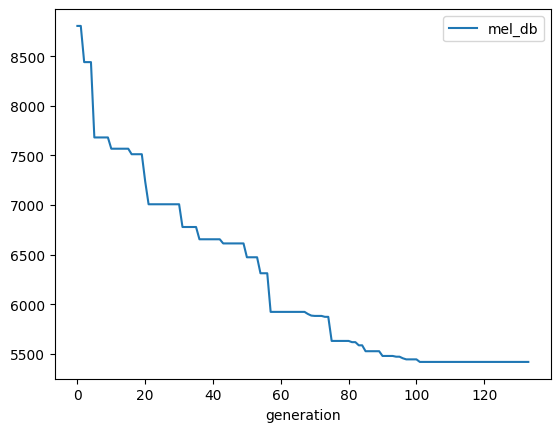

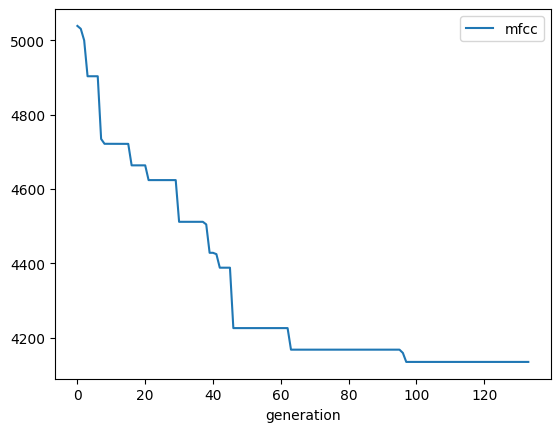

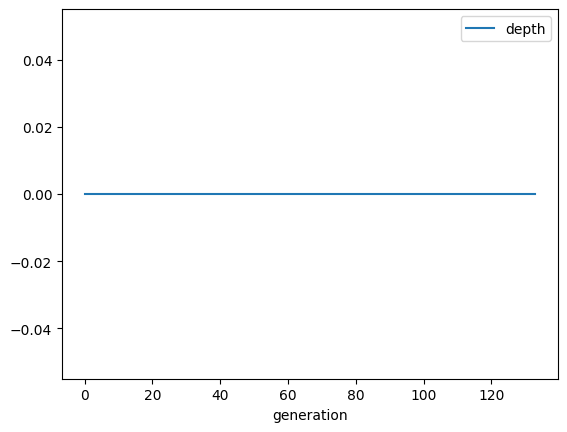

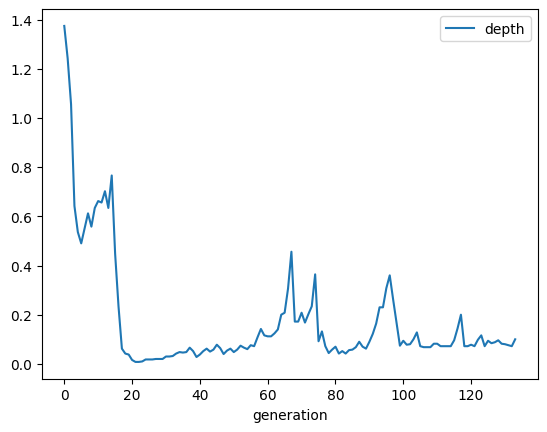

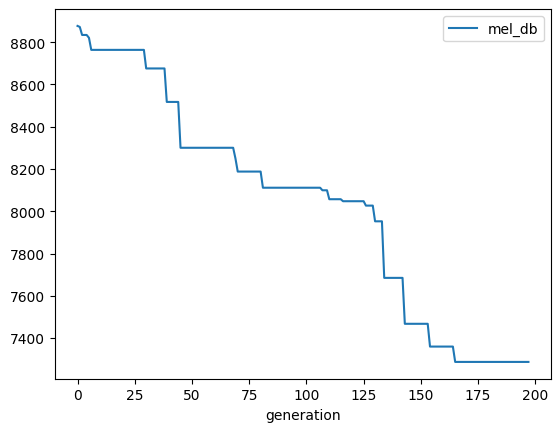

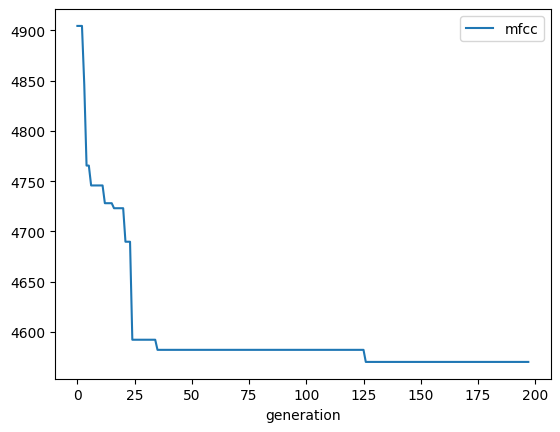

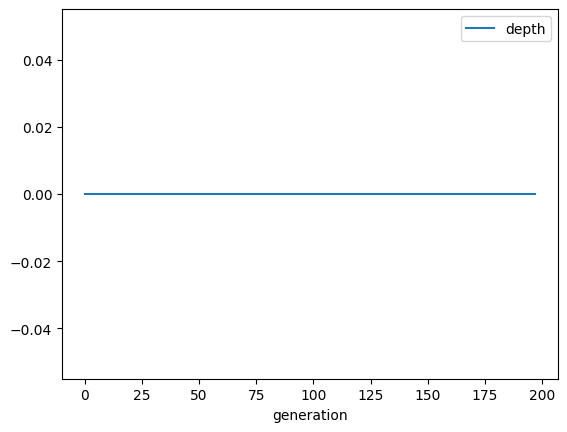

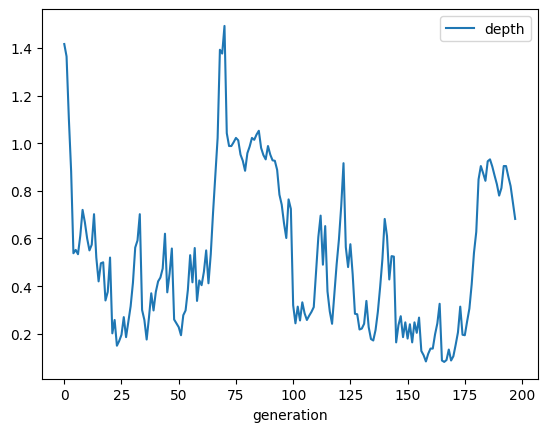

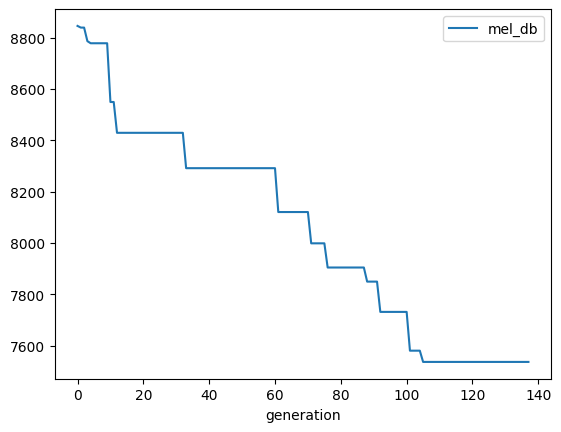

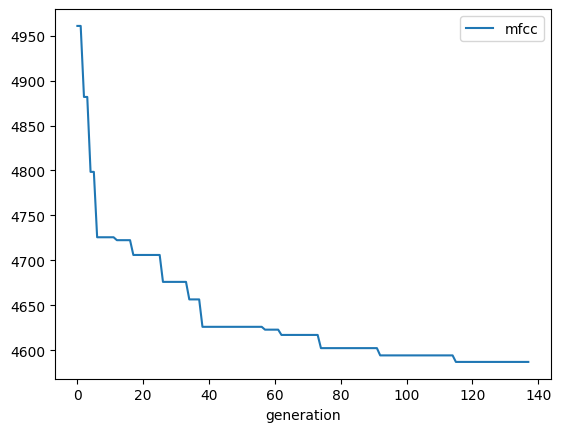

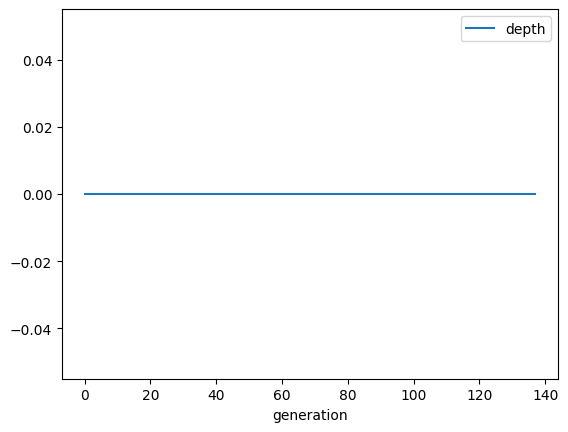

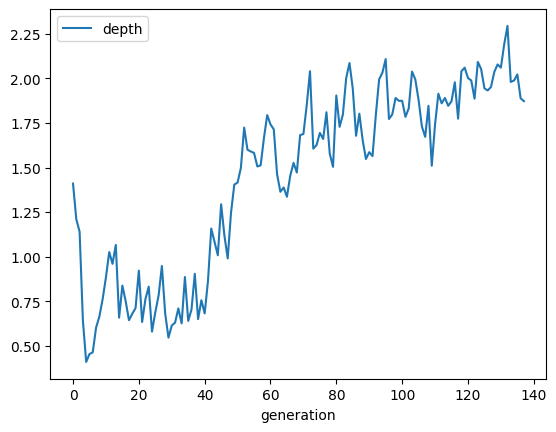

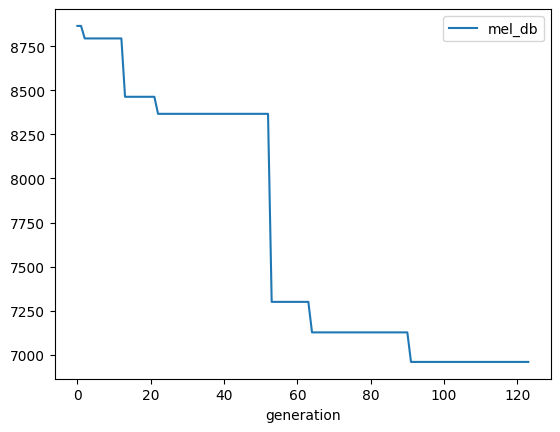

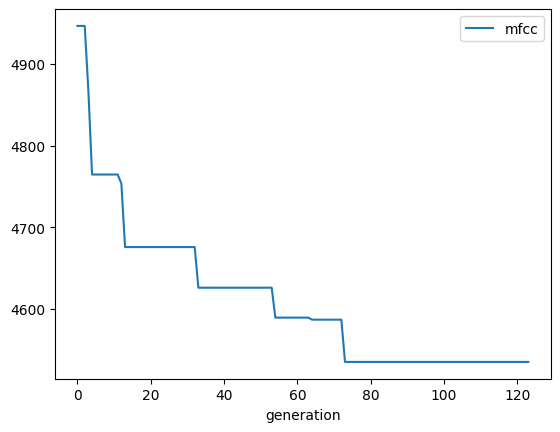

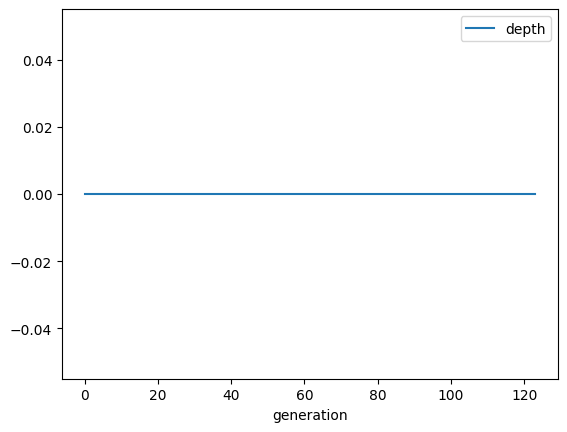

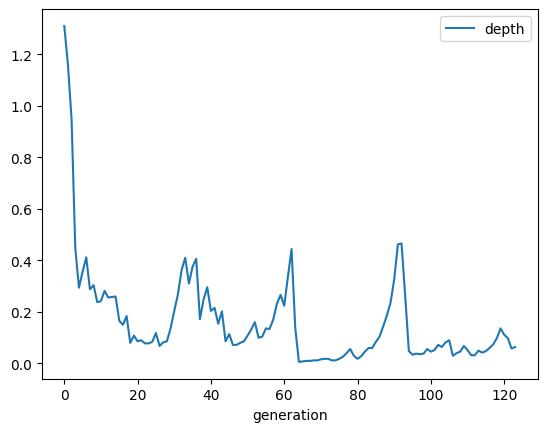

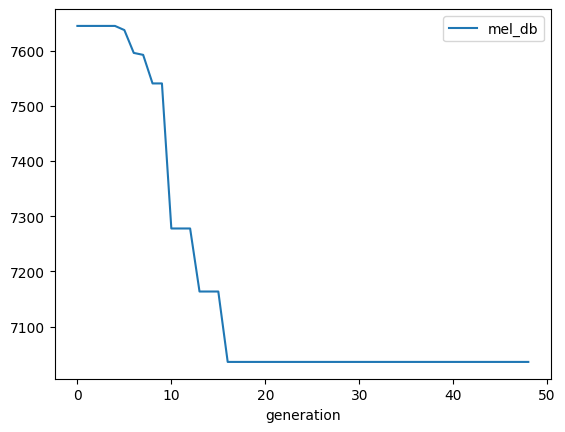

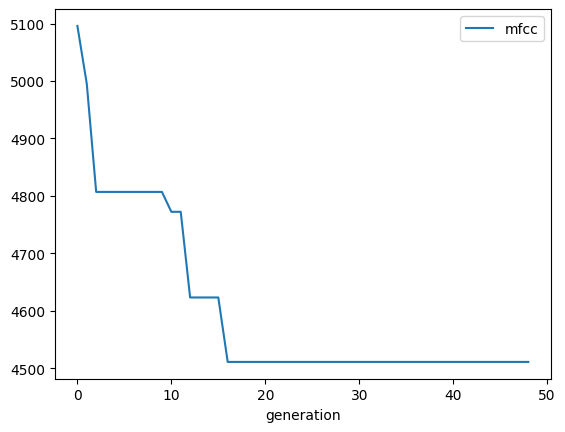

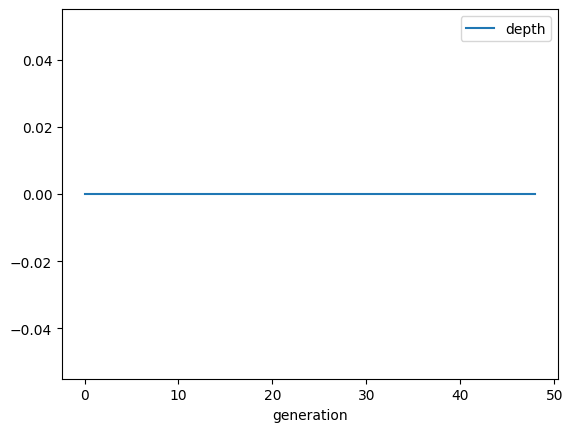

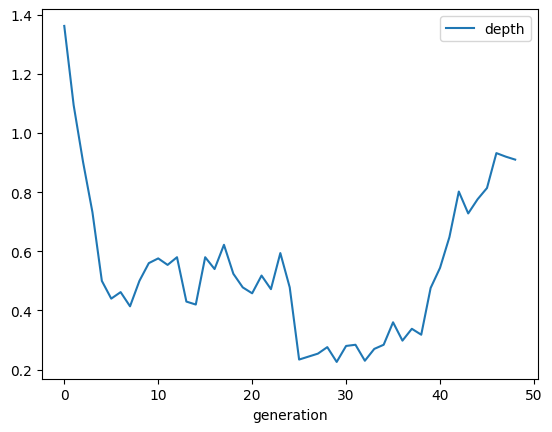

In [35]:
k = 5
for selection in selection_widget.value:
    for trial in range(k):
        export_run(f'/{selection}/{trial:02d}')

In [36]:
print("Done!")

Done!
